# Generation of Topologically Associated Domains and their Boundaries 

## Description

During fine mapping we often use cis window (up & downstream 1M base of te start of gene) as the fine mapping region. However, this method lacks justification in biological level, so we will use topologically associated domains (TAD) to create a list of fine mapping regions.

We use generalized TAD region lists created from the merging of TAD data from hippocampus and cortex brain tissues obtained from [[cf. McArthur et al (2021)](https://doi.org/10.1016%2Fj.ajhg.2021.01.001) and [[cf. Schmitt et al (2017)](https://doi.org/10.1016%2Fj.celrep.2016.10.061). Variants within boundaries may also have an effect on gene expresion, so we explore how to extend TAD regions to the adjacent boundaries (TADB), in an attempt to not leave out any possible causal variants. 

However, we are trying to be conservative, so we do not want to lose information gained from the use of 1Mb cis windows. Therefore, we want to extend those regions. Here we extend both TADB and TADB-enhanced cis windows since each has a different goal.

To build a list of extended TADB, we start with generalized TADB. We find all genes within each TADB and get their start and end positions extended by 1Mb cis windows. We then take the outmost boundary of all the !M cis windows and this TADB as the boundary of the extended TADB. We end with 1,381 TADBs which may then be used as functional units of epigenetic analysis. 

To build a list of TADB-enhanced cis windows, we start with the cis window of each gene. We take the outermost boundary of the generalized TADB the gene is in and the 1Mb cis window of the gene as the boundary of the TADB-enhanced cis window. If one gene is in two generalized TADBs, we take the outermost of both the TADB and cis window. We end with a cis window for each gene.



## Input
+ `Cortex_DLPFC_Schmitt2016-raw_TADs.txt` and `Hippocampus_Schmitt2016-raw_TADs.txt` for initial TAD data. Obtained from [[cf. McArthur et al (2021)](https://doi.org/10.1016%2Fj.ajhg.2021.01.001) including hg38 TAD regions in cortex and hippocampal tissues collected by [[cf. Schmitt et al (2017)](https://doi.org/10.1016%2Fj.celrep.2016.10.061). These are used to define the genotype cis region for fine mapping with different phenotypes. These TAD regions may be downloaded [here](http://3dgenome.fsm.northwestern.edu/publications.html).

+ `Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.ERCC.gtf`，downloaded from https://www.synapse.org/#!Synapse:syn36419586.

## Output
+ Generalized TAD: `generalized_TAD.tsv`

+ Generalized TADB : `generalized_TADB.tsv`

+ TADB-enhanced cis window: (also in fungen-xqtl github) `TADB_enhanced_cis.bed`

+ Extended TADB: (also in fungen-xqtl github)
`extended_TADB.bed`

## Minimal Working Example Steps

### i. Manage TAD Redundancy

Timing: ~20 min

```
# merge the TADs to one file
cat ../../reference_data/TAD/Hippocampus_Schmitt2016-raw_TADs.txt ../../reference_data/TAD/Cortex_DLPFC_Schmitt2016-raw_TADs.txt > ../../reference_data/TAD/brain_TADs.txt
```

In [26]:
library(tidyverse)

In [27]:

find_TAD_overlap <- function(x, inputDF){
    rowChr <- x['chr']
    rowStart <- as.numeric(x['start'])
    rowEnd <- as.numeric(x['end'])
    rowTADIndex <- x['TAD_index']

    TADsubset <- inputDF %>% filter(chr == rowChr) 
    TADsubset$start <- as.numeric(TADsubset$start)
    TADsubset$end <- as.numeric(TADsubset$end)

    priorTADsubset <- TADsubset %>%
        filter(start <= rowStart & rowStart <= end &
              (start != rowStart | end != rowEnd)) %>%
        arrange(start)
    nextTADsubset <- TADsubset %>%
        filter(start <= rowEnd & rowEnd <= end &
              (start != rowStart | end != rowEnd)) %>%
        arrange(-end)
    completeOverlapSubset <- TADsubset %>%
        filter(start <= rowStart & rowEnd <= end &
              (start != rowStart | end != rowEnd))
    
    priorOverlap <- 0
    prior_TAD_index <- rowTADIndex
    nextOverlap <- 0
    next_TAD_index <- rowTADIndex
    completeOverlap <- FALSE

    if (nrow(priorTADsubset)) {
        priorOverlap <- priorTADsubset %>%
            mutate(
                inner_TAD_Length = end - rowStart,
                outer_TAD_Length = end - start,
            overlap = (inner_TAD_Length / outer_TAD_Length) * 100) %>%
            arrange(-overlap)
        prior_TAD_index <- priorOverlap$TAD_index[1]
        priorOverlap <- priorOverlap$overlap[1]
        if(is.na(prior_TAD_index)) stop(paste("The following TAD has an issue:", rowTADIndex))
    }
    
    
    if (nrow(nextTADsubset)) {
        nextOverlap <- nextTADsubset %>%
            mutate(
                inner_TAD_Length = rowEnd - start,
                outer_TAD_Length = end - start,
            overlap = (inner_TAD_Length / outer_TAD_Length) * 100) %>%
            arrange(-overlap)
        next_TAD_index <- nextOverlap$TAD_index[1]
        nextOverlap <- nextOverlap$overlap[1]
        if(is.na(next_TAD_index)) stop(paste("The following TAD has an issue:", rowTADIndex))
    }
    
    if (nrow(completeOverlapSubset)) {
        completeOverlap <- TRUE
    }
    
    return(list(prior=as.character(priorOverlap), subsequent=as.character(nextOverlap), com=as.character(completeOverlap), prior_tad=as.character(prior_TAD_index), next_tad=as.character(next_TAD_index)))
}

merge_TADs <- function(x, inputDF, cutoff = 80){
    rowChr <- x["chr"]
    rowStart <- as.numeric(x["start"])
    rowEnd <- as.numeric(x["end"])
    rowTADIndex <- as.character(x['TAD_index'])
    rowPriorOverlap <- as.double(x["prior_overlap"])
    rowPriorTADIndex <- as.character(x["prior_TAD_index"])
    rowNextOverlap <- as.double(x["next_overlap"])
    rowNextTADIndex <- as.character(x["next_TAD_index"])
    
    newStart <- rowStart
    newEnd <- rowEnd
    
    if (rowNextOverlap >= cutoff && rowNextTADIndex != rowTADIndex) {
        newEnd <- inputDF %>%
            filter(TAD_index == rowNextTADIndex)
        if(is.na(newEnd %>% pull(end) %>% length())) print(newEnd$end[1])
        newEnd <- newEnd$end[1]
    }
    
    if (rowPriorOverlap >= cutoff & rowPriorTADIndex != rowTADIndex) {
        newStart <- inputDF %>%
            filter(TAD_index == rowPriorTADIndex)
        newStart <- newStart$start[1]
    }
    
    return(list(newstart=newStart, newend=newEnd))
}

recursive_merge <- function(tadDF){
    tadDF$TAD_index <- paste0('TAD_', seq(1, nrow(tadDF)))

    overlap_results <- apply(tadDF, 1, find_TAD_overlap, tadDF) # First Call
    tadDF$prior_overlap <- as.double(lapply(overlap_results, "[[", 'prior'))
    tadDF$prior_TAD_index <- as.character(lapply(overlap_results, "[[", 'prior_tad'))
    tadDF$next_overlap <- as.double(lapply(overlap_results, "[[", 'subsequent'))
    tadDF$next_TAD_index <- as.character(lapply(overlap_results, "[[", 'next_tad'))
    tadDF$complete_overlap <- as.logical(lapply(overlap_results, "[[", 'com'))

    merge_results <- apply(tadDF, 1, merge_TADs, tadDF, 80)
    tadDF$end <- as.numeric(lapply(merge_results, "[[", 'newend'))
    tadDF$start <- as.numeric(lapply(merge_results, "[[", 'newstart'))
    candidateDF <- tadDF %>% distinct(chr, start, end, .keep_all=TRUE)
    
    if (nrow(tadDF) == nrow(candidateDF)) {
        return(candidateDF)
    } else {
        candidateDF$TAD_index <- paste0('TAD_', seq(1, nrow(candidateDF)))
        overlap_results <- apply(candidateDF, 1, find_TAD_overlap, candidateDF) # First Call
        candidateDF$prior_overlap <- as.double(lapply(overlap_results, "[[", 'prior'))
        candidateDF$prior_TAD_index <- as.character(lapply(overlap_results, "[[", 'prior_tad'))
        candidateDF$next_overlap <- as.double(lapply(overlap_results, "[[", 'subsequent'))
        candidateDF$next_TAD_index <- as.character(lapply(overlap_results, "[[", 'next_tad'))
        candidateDF$complete_overlap <- as.logical(lapply(overlap_results, "[[", 'com'))
        candidateDF <- candidateDF %>% filter(complete_overlap == FALSE)

        candidateDF$TAD_index <- paste0('TAD_', seq(1, nrow(candidateDF)))
        overlap_results <- apply(candidateDF, 1, find_TAD_overlap, candidateDF) # Second Call
        candidateDF$prior_overlap <- as.double(lapply(overlap_results, "[[", 'prior'))
        candidateDF$prior_TAD_index <- as.character(lapply(overlap_results, "[[", 'prior_tad'))
        candidateDF$next_overlap <- as.double(lapply(overlap_results, "[[", 'subsequent'))
        candidateDF$next_TAD_index <- as.character(lapply(overlap_results, "[[", 'next_tad'))
        candidateDF$complete_overlap <- as.logical(lapply(overlap_results, "[[", 'com'))

        return(recursive_merge(candidateDF))
    }
}

#### Merge TADs With Neighboring TABs
Includes a step to manually correct the start and end position of each chromosome.

In [28]:
general_tad_path = "../../reference_data/TAD/brain_TADs.txt"
general_TAD_DF <- read_tsv(general_tad_path, col_names=c('chr', 'start', 'end'), show_col_types = FALSE)
general_TAD_DF <- general_TAD_DF[with(general_TAD_DF, order(chr, start, -end)),]
general_TAD_DF$TAD_index <- paste0('TAD_', seq(1,nrow(general_TAD_DF)))

#### Preliminary Merges
Remove duplicates (same chr, start, and end).

In [29]:
general_TAD_DF <- general_TAD_DF[with(general_TAD_DF, order(chr, start, -end)),]

head(general_TAD_DF)

# Initial Number of TADs
paste("Initial number of TADs before removing redundancy:", nrow(general_TAD_DF))

# Remove duplicate TAD sites
general_TAD_DF <- general_TAD_DF %>% distinct(chr, start, end, .keep_all=TRUE) %>% arrange(chr, start, end)
paste("Number of TADs left after removing duplicate TADs:", nrow(general_TAD_DF))

reduced_TAD_DF <- general_TAD_DF
reduced_TAD_DF$TAD_index <- paste0('TAD_', seq(1,nrow(reduced_TAD_DF)))

nrow(reduced_TAD_DF)
head(reduced_TAD_DF)

chr,start,end,TAD_index
<chr>,<dbl>,<dbl>,<chr>
chr1,760000,6160000,TAD_1
chr1,800000,6120000,TAD_2
chr1,6480000,7640000,TAD_3
chr1,6480000,7600000,TAD_4
chr1,7920000,9480000,TAD_5
chr1,7960000,9520000,TAD_6


[1] "Initial number of TADs before removing redundancy: 2973"

[1] "Number of TADs left after removing duplicate TADs: 2652"

[1] 2652

chr,start,end,TAD_index
<chr>,<dbl>,<dbl>,<chr>
chr1,760000,6160000,TAD_1
chr1,800000,6120000,TAD_2
chr1,6480000,7600000,TAD_3
chr1,6480000,7640000,TAD_4
chr1,7920000,9480000,TAD_5
chr1,7960000,9520000,TAD_6


#### Determining Overlap
Determining the overlap between TADs is important for the later merging steps. In this step, we find:

* Overlap between a TAD and the preceding TAD
* Overlap between a TAD and the following TAD
* TADs that are entirely contained within another TAD
##### Overlap Check
There are two values for the following overlap checks. The first value is the overlap with the preceding TAD, and the second value is the overlap of the following TAD.

In [30]:
# Compute overlap
overlap_results <- apply(reduced_TAD_DF, 1, find_TAD_overlap, reduced_TAD_DF)
reduced_TAD_DF$prior_overlap <- as.double(lapply(overlap_results, "[[", 'prior'))
reduced_TAD_DF$prior_TAD_index <- as.character(lapply(overlap_results, "[[", 'prior_tad'))
reduced_TAD_DF$next_overlap <- as.double(lapply(overlap_results, "[[", 'subsequent'))
reduced_TAD_DF$next_TAD_index <- as.character(lapply(overlap_results, "[[", 'next_tad'))
reduced_TAD_DF$complete_overlap <- as.logical(lapply(overlap_results, "[[", 'com'))

paste("Number of TADs with 100% overlap:", nrow(reduced_TAD_DF %>% filter(complete_overlap == TRUE)))
paste("Number of TADs with greater than 80% overlap:", nrow(reduced_TAD_DF %>% filter(prior_overlap > 80)), nrow(reduced_TAD_DF %>% filter(next_overlap > 80)))
paste("Number of TADs with greater than 50% overlap:", nrow(reduced_TAD_DF %>% filter(prior_overlap > 50)), nrow(reduced_TAD_DF %>% filter(next_overlap > 50)))
paste("Number of TADs with greater than 25% overlap:", nrow(reduced_TAD_DF %>% filter(prior_overlap > 25)), nrow(reduced_TAD_DF %>% filter(next_overlap > 25)))
paste("Number of TADs with greater than 10% overlap:", nrow(reduced_TAD_DF %>% filter(prior_overlap > 10)), nrow(reduced_TAD_DF %>% filter(next_overlap > 10)))

[1] "Number of TADs with 100% overlap: 1030"

[1] "Number of TADs with greater than 80% overlap: 1386 1379"

[1] "Number of TADs with greater than 50% overlap: 1531 1546"

[1] "Number of TADs with greater than 25% overlap: 1630 1634"

[1] "Number of TADs with greater than 10% overlap: 1682 1686"

#### Recursively Merge TADs
##### Overview
1. Extend the given TAD to the overlapped TAD position
    * If a given TAD overlaps the prededing TAD, extend the start position
    * If a given TAD overlaps the subsequent TAD, extend the end position
    * If a given TAD overlaps both ends, extend both
2. Remove TADs that are completely overlapped
3. If the TAD is reduced, compute the overlap for the reduced dataframe and rerun the merging function until the dataframe dimensions stop changing

In [31]:
final_brain_TAD_DF <- recursive_merge(reduced_TAD_DF %>% filter(complete_overlap == FALSE))
paste("Number of TADs in the finalized TAD dataset:", nrow(final_brain_TAD_DF))
print("Preview of the finalized TAD dataset:")
final_brain_TAD_DF %>% subset(select=c("chr", "start", "end")) %>% head()

[1] "Number of TADs in the finalized TAD dataset: 1401"

[1] "Preview of the finalized TAD dataset:"


chr,start,end
<chr>,<dbl>,<dbl>
chr1,760000,6160000
chr1,6480000,7640000
chr1,7920000,9520000
chr1,9880000,10480000
chr1,10520000,12040000
chr1,12040000,12840000


In [32]:
overlap_results <- apply(final_brain_TAD_DF, 1, find_TAD_overlap, final_brain_TAD_DF)
final_brain_TAD_DF$prior_overlap <- as.double(lapply(overlap_results, "[[", 'prior'))
final_brain_TAD_DF$prior_TAD_index <- as.character(lapply(overlap_results, "[[", 'prior_tad'))
final_brain_TAD_DF$next_overlap <- as.double(lapply(overlap_results, "[[", 'subsequent'))
final_brain_TAD_DF$next_TAD_index <- as.character(lapply(overlap_results, "[[", 'next_tad'))
final_brain_TAD_DF$complete_overlap <- as.logical(lapply(overlap_results, "[[", 'com'))

In [33]:
paste("Number of TADs with 100% overlap:", nrow(final_brain_TAD_DF %>% filter(complete_overlap == TRUE)))
paste("Number of TADs with greater than 80% overlap:", nrow(final_brain_TAD_DF %>% filter(prior_overlap > 80)), nrow(final_brain_TAD_DF %>% filter(next_overlap > 80)))
paste("Number of TADs with greater than 50% overlap:", nrow(final_brain_TAD_DF %>% filter(prior_overlap > 50)), nrow(final_brain_TAD_DF %>% filter(next_overlap > 50)))
paste("Number of TADs with greater than 25% overlap:", nrow(final_brain_TAD_DF %>% filter(prior_overlap > 25)), nrow(final_brain_TAD_DF %>% filter(next_overlap > 25)))
paste("Number of TADs with greater than 10% overlap:", nrow(final_brain_TAD_DF %>% filter(prior_overlap > 10)), nrow(final_brain_TAD_DF %>% filter(next_overlap > 10)))


[1] "Number of TADs with 100% overlap: 0"

[1] "Number of TADs with greater than 80% overlap: 0 0"

[1] "Number of TADs with greater than 50% overlap: 14 19"

[1] "Number of TADs with greater than 25% overlap: 26 31"

[1] "Number of TADs with greater than 10% overlap: 39 39"

In [34]:
formatted_final_DF <- final_brain_TAD_DF %>% filter(chr %in% paste0('chr', seq(1,22)) & complete_overlap == FALSE) %>% subset(select=c("chr", "start", "end")) 
formatted_final_DF$TAD_index <- paste0('TAD', seq(1,nrow(formatted_final_DF)))
formatted_final_DF$end <- as.numeric(formatted_final_DF$end)
formatted_final_DF$start <- as.numeric(formatted_final_DF$start)

formatted_final_DF <- formatted_final_DF %>% mutate(
    TAD_Length = end - start)

quantile(formatted_final_DF$TAD_Length, c(0.19,0.25,0.5,0.75,0.95,0.99,0.995,1))

19%     25%     50%     75%     95%     99%   99.5%    100% 
 917200 1040000 1680000 2520000 3880000 5200000 5551800 6080000

In [35]:
formatted_final_DF <- final_brain_TAD_DF %>% subset(select=c("chr", "start", "end"))
formatted_final_DF$start <- format(formatted_final_DF$start, scientific = FALSE)
formatted_final_DF$end <- format(formatted_final_DF$end, scientific = FALSE)
write.table(
    formatted_final_DF,
    "../../reference_data/TAD/generalized_TAD.tsv",
    sep="\t",
    append=FALSE,
    row.names=FALSE,
    col.names=FALSE,
    quote=FALSE)

## ii. Generate TADB-enhanced cis windows and extended TADBs

Timing: ~20 min

#### How to find boundaries and build TADB?

After we had the generalized TAD, it's not the simple case that all intervals between TADs are the boundaries.
The ideal (and most of) generalized TADs have a structure like this:

<img src="TADB_idealcase.png" width=800 height=800 />

The black line is the genome. Red and blue shaded triangles are TAD results from hippo/cortex, respectively.
In the later code we will denote them as **specific TAD** because they are specific to one tissue.

The two specific TAD lists (blue and red) don't have overlaps internally. But if we pool them together, red and blue overlap. If their overlap exceeds **80%**, they will be merged to a larger TAD, called **Generalized TAD** (Green triangle). That's how we get the generalized TAD list.

However, it's not necessary that specific TAD line up in this way, so there are more cases. For example, if two specific TAD **do not overlap enough**, or one specific TAD does not even overlap with any other TADs, then they will both one generalized TAD **solely**. The diagram is shown as below.

<img src="sole_case.png" width=800 height=800 />


We can see from the ideal case, at the boundary of generalized TAD, there are regions not covered by all two specific TADs, which means not all information belongs to a TAD, so it can belong to TAB (boundary regions).
That's how we define a **Generalized TAB**, not only the intervals, but also include the ambigous regions. They are shown as the **yellow** triangles in the diagram.


![](TADB_diagram.png)

Then to get TADBs, we will include the generalized TAD and adjacent TABs. In the diagram for generalized TAD2, the TADB will be (generalized) TAB1 + TAD2 + TAB2.

Solely formed generalized TAD have no ambiguous regions, so their boundaries will also be boundaries of generalized TAB.
Here we give a example. 

We search for the last TADs right boundary and extend there, then search for the next TADs left boundary and extend there.
Note: if two generalized TAD overlap, we will serach for the boundary of non-overlapping one.

It's not hard to find that under this definition, TAD2 and TAD3 share the same TADB.
    
![](TADB_solely.png)

So now our strategy is to work out a list of left boundaries and right boundaries. For a generalized TAD formed by two or more specific TADs, the left boundary will be the start of the second specific TAD forming this generalized TAD.
For a generalized TAD formed solely by one, then the left boundary is just the start of this generlized TAD.

It's similar for the right boundaries, the only difference we use the last but one specific TADs end as the right boundary. Here are the diagrams.

Left boundary will be labled as red vertical lines, right will be labeld as blue verticle lines. The definition also fits for more complicated cases.


![](left_right.png)

After having these boundaries our strategy to get TADB will be to search from start of generalized TAD, extend left side to last right boundary (including the start of chromosome, 0). Search from end of generalized TAD, extend right side to the next left boundary (including the end of each chromosomes).

#### TADB - coding

Total number of generalized TADs: 1401.

Then we checked how many specific TAD forms each generalized TAD. That's because as shown above, those generalized TAD formed by one vs more specific TADs, will have different "boundaries".

Here we begin with a gtf to get the start and end of a gene.

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import subprocess
import gzip

def gtf_to_start_end_bed(annotation_gtf, feature='gene', exclude_chrs=[], phenotype_id='gene_id'):
    """Parse genes and starts and ends from GTF and return DataFrame for BED output"""
    chrom = []
    start = []
    end = []
    gene_id = []
    gene_name = []

    if annotation_gtf.endswith('.gz'):
        opener = gzip.open(annotation_gtf, 'rt')
    else:
        opener = open(annotation_gtf, 'r')

    with opener as gtf:
        for row in gtf:
            row = row.strip().split('\t')
            if row[0][0] == '#' or row[2] != feature: continue # skip header
            chrom.append(row[0])

            # extract start and end
            if row[6] == '+':
                start.append(np.int64(row[3]) -1)
                end.append(np.int64(row[4]))
            elif row[6] == '-':
                start.append(np.int64(row[3]))  # last base of gene
                end.append(np.int64(row[4]))
            else:
                raise ValueError('Strand not specified.')

            attributes = defaultdict()
            for a in row[8].replace('"', '').split(';')[:-1]:
                kv = a.strip().split(' ')
                if kv[0]!='tag':
                    attributes[kv[0]] = kv[1]
                else:
                    attributes.setdefault('tags', []).append(kv[1])

            gene_id.append(attributes['gene_id'])
            gene_name.append(attributes['gene_name'])

    if phenotype_id == 'gene_id':
        bed_df = pd.DataFrame(data={'chr':chrom, 'start':start, 'end':end, 'gene_id':gene_id}, columns=['chr', 'start', 'end', 'gene_id'], index=gene_id)
    elif phenotype_id == 'gene_name':
        bed_df = pd.DataFrame(data={'chr':chrom, 'start':start, 'end':end, 'gene_id':gene_name}, columns=['chr', 'start', 'end', 'gene_id'], index=gene_name)
    # drop rows corresponding to excluded chromosomes
    mask = np.ones(len(chrom), dtype=bool)
    for k in exclude_chrs:
        mask = mask & (bed_df['chr']!=k)
    bed_df = bed_df[mask]

    # sort by start position
    bed_df = bed_df.groupby('chr', sort=False, group_keys=False).apply(lambda x: x.sort_values('start'))

    return bed_df
#../../reference_data/TAD/generalized_TAD.ts
# save the bed files recording start and end of a chromosome
bed_template_df_id = gtf_to_start_end_bed("../../reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.ERCC.gtf", feature='gene',phenotype_id = "gene_id" )
bed_template_df_name = gtf_to_start_end_bed("../../reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.ERCC.gtf", feature='gene',phenotype_id = "gene_name")
bed_template_df = bed_template_df_id.merge(bed_template_df_name, on = ["chr","start","end"])
bed_template_df.columns = ["#chr","start","end","gene_id","gene_name"]
bed_template_df.to_csv("../../reference_data/TAD/gene_start_end.tsv", sep="\t")

In [36]:
# generalized TAD, already merged if have > 80% overlap
library("tidyverse")
general <- read_tsv("../../reference_data/TAD/generalized_TAD.tsv", col_names = c("chr", "start", "end")) %>% mutate(row_index = row_number())

# Specific TADs list -- belong to one of the tissue we interested in
specific <- read_tsv("../../reference_data/TAD/brain_TADs.txt", col_names = c("chr", "start", "end")) %>% mutate(row_index = row_number())

# for each generalized TAD, how many specific TADs they are formed from?

check_TAD = function(chrm, start_pos, end_pos){
    within_TAD = specific %>% filter(chr == chrm & start >= start_pos & end <= end_pos)
    within_TAD_num = nrow(within_TAD)
    return(within_TAD_num)
}

general_number = general %>% mutate(within_num = pmap(list(chrm = chr, 
            start_pos = start, end_pos = end), check_TAD))

general_number %>% group_by(within_num) %>% count()

Rows: 1401 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2973 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


within_num,n
<list>,<int>
2,1163
3,188
4,11
1,39


Most of the generalized TADs are include 2 specific TADs.

There are cases that one generalized TAD is forming from 4, but even for these cases, our strategy still works.

##### Find left boundaries

Left boundaries should include the **end** of the chromosome -- because left boundaries of TADs will be the right boundary of former TADB. For the last one TADB, is should have the end of chromosome as its right boundary.

In [37]:
# a list showing the end position of each chromosome, including chrX

chromosomes <- paste0('chr', seq(1:22))
chromosomes = c(chromosomes,"chrX")
bplengths <- c(248956422, 242193529, 198295559, 190214555, 181538259, 170805979, 159345973, 145138636,
                 138394717, 133797422, 135086622, 
               133275309, 114364328, 107043718, 101991189, 90338345, 83257441, 
               80373285, 58617616, 64444167, 46709983, 50818468, 156040895)

chrDF <- data.frame(chr = chromosomes, left = bplengths)

In [38]:
find_left_boundary = function(chrm, start_pos, end_pos){
    within_TAD = specific %>% filter(chr == chrm & start >= start_pos & end <= end_pos)
    within_TAD_num = nrow(within_TAD)
    if(within_TAD_num == 1){
        # if formed only by one, then the first start of specific TAD
        left = within_TAD %>% pull(start) %>% as.integer()
    }else{
        # if formed by more than 2, then the second start of specific TAD
        TAD_start_list = within_TAD %>% pull(start) %>% sort()
        left = TAD_start_list[2] %>% as.integer()
    }
    return(left)
}

# find all left_boundaries

left_table = general %>% mutate(left = pmap(list(chrm = chr, 
            start_pos = start, end_pos = end), find_left_boundary)) %>% 
            select(chr, left) %>% mutate(left = as.integer(left))

# combine left boundaries with end of chromosome to form the final left boundary list

left_table_final = rbind(left_table, chrDF)

##### Find right boundaries

In [39]:
find_right_boundary = function(chrm, start_pos, end_pos){
    within_TAD = specific %>% filter(chr == chrm & start >= start_pos & end <= end_pos)
    within_TAD_num = nrow(within_TAD)
    if(within_TAD_num == 1){
        right = within_TAD %>% pull(end) %>% as.integer()
    }else{
        TAD_end_list = within_TAD %>% pull(end) %>% sort(decreasing = T)
        right = TAD_end_list[2] %>% as.integer()
    }
    return(right)
}

right_table = general %>% mutate(right = pmap(list(chrm = chr, 
            start_pos = start, end_pos = end), find_right_boundary)) %>% 
            select(chr, right) %>% mutate(right = as.integer(right))

# Similarly, we should include start of the chromosome to be the first right boundaries

chr_start = tibble(chr = chromosomes, 
                  right = 0)

right_table_final = rbind(right_table, chr_start)

##### Map each TAD to the closest left_right boundary

In [40]:
# In the list of left boundary, find the closet next one 

find_next_boundary = function(chrm, end_pos){
    left_boundaries = left_table_final %>% filter(chr == chrm, left >= end_pos) %>%
        pull(left) %>% sort()
    first_left = left_boundaries[1]
    return(first_left)
}

# In the list of right boundary, find the closet previous one 
find_previous_boundary = function(chrm, start_pos){
    right_boundaries = right_table_final %>% filter(chr == chrm, right <= start_pos) %>%
        pull(right) %>% sort(decreasing = T)
    first_right = right_boundaries[1]
    return(first_right)
}

TADB = general %>% mutate(previous_bound = pmap(list(chr, start), find_previous_boundary),
    next_bound = pmap(list(chr, end), find_next_boundary)) %>% 
    select(-start, -end) %>% rename(start = previous_bound) %>%
    rename(end = next_bound) %>% mutate(start = as.integer(start), end = as.integer(end)) %>% 
    select(chr, start, end)

nrow(TADB)

[1] 1401

After extending to TADB, the number of regions did not change, which should be that case.
However, after merging, some of the TADBs will be totally covered by other TADBS. An example is shown here.

Genralized TAD0 and 4 not drawn. But for generalized TAD1, TADB fromed by it will be totally a subset of TADB 2, which is the extension of generalized TAD2.
(Blue: right boundary, red: left_boundary)


![](overlap.png)

Here we will use two steps to exclude those TADBs that are fully covered by other single TADBs (including the case that two TADBs are identical)

In [41]:
TADB = TADB %>% distinct()

# if we don't use dintinct above, then the identical TADBS will all be removed
# that's not we want, we still want to leave one copy there

if_fully_cover = function(chrm, start_pos, end_pos){
    potential = TADB %>% filter(chr == chrm, start <= start_pos, end >= end_pos)
    if(nrow(potential) <= 1){
        return(0)
    }else{
        return(1)
    }
}

TADB_final = TADB %>% mutate(cover_status = pmap(list(chrm = chr, start_pos = start, end_pos = end), if_fully_cover)) %>% 
    filter(cover_status != 1) %>% mutate(index = paste0("TADB", row_number())) %>% select(- cover_status) %>%
    rename(`#chr` = chr)

nrow(TADB_final)

[1] 1381

After removing subsets and duplicates, there will be 1381 TADBs.

In [42]:
# save the TADB final result
write_tsv(TADB_final, "../../reference_data/TAD/generalized_TADB.tsv")

#### Length distribution of generalized TADs

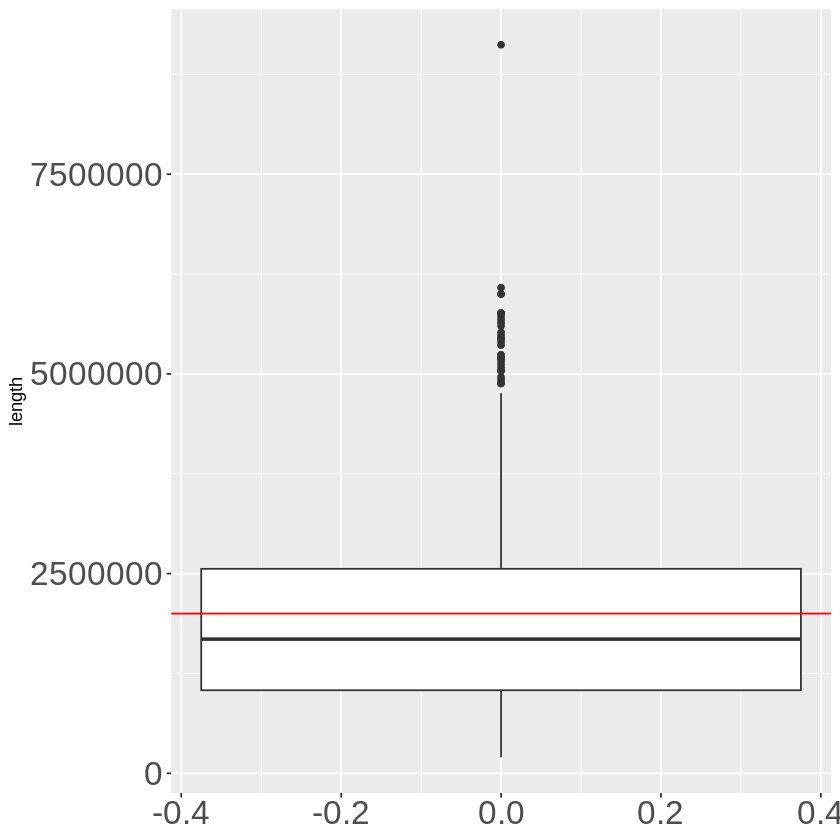

In [43]:
## Length distribution of generalized TADs

general %>% mutate(length = end - start) %>% ggplot(aes(y = length)) + geom_boxplot() +
    geom_hline(yintercept = 2000000, color = "red")+ theme(axis.text = element_text(size = 20)) 

The average length is a little bit shorter than 2M.

#### Length distribution of general TADBs

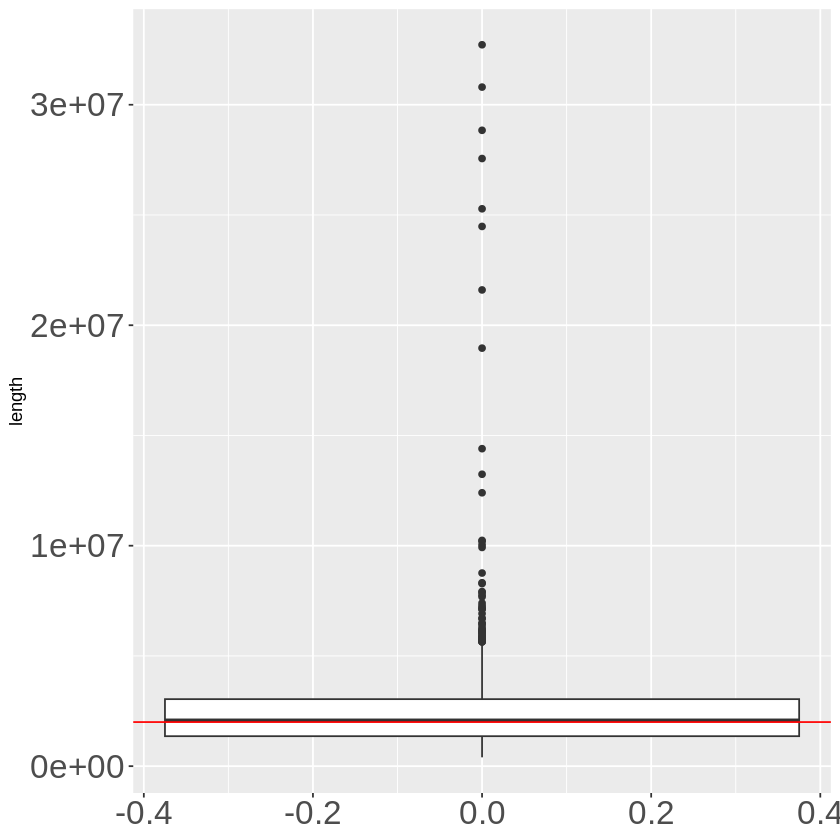

In [44]:
## Length distribution of general TADBs

TADB_final %>% mutate(length = end - start) %>% ggplot(aes(y = length)) + geom_boxplot() +
    geom_hline(yintercept = 2000000, color = "red")+ theme(axis.text = element_text(size = 20))  

The average length is a little bit longer than 2M. Yet, the extreme case number increases.

In [45]:
# average length of generalized TAD

general %>% mutate(length = end - start) %>% pull(length) %>% mean()

# average length of TADB

TADB_final %>% mutate(length = end - start) %>% pull(length) %>% mean()

[1] 1920022

[1] 2512992

TADB, as expected, is longer than TAD because it includes boundaries.

#### Compare TADB and cis windows

Each TADB covers many genes. For each gene we will extend a 1M window for finemapping. We now checking if the TADBs can cover all 1M windows for genes inside of them.

In [47]:
all_gene <- read_tsv("../../reference_data/TAD/gene_start_end.tsv")

New names:
• `` -> `...1`
Rows: 60672 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): #chr, gene_id, gene_name
dbl (3): ...1, start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [48]:
all_gene = all_gene %>% select(-`...1`, -gene_name) %>% rename(chr = `#chr`, gene_start = start,
                                                              gene_end = end)  %>% distinct()

In [49]:
nrow(all_gene)

[1] 60668

First step, we try to verify if all genes are covered by TADB, if not, TADB may be wrong (since they should cover the whole genome)

In [50]:
# check if we have leave out any genes

TADB_final = TADB_final %>% rename(chr = "#chr")

# find the corresponding TADB of one gene

gene_TADB_tb = left_join(all_gene, TADB_final, by = "chr", relationship = "many-to-many") %>% 
    filter(!(gene_start > end) &  !(gene_end < start))

genes = gene_TADB_tb %>% pull(gene_id)

all_genes = all_gene %>% pull(gene_id)

dif = setdiff(all_genes, genes)

all_gene %>% filter(gene_id %in% dif) %>% pull(chr) %>% unique()

[1] "chrY"       "chrMT"      "ERCC_00002" "ERCC_00003" "ERCC_00004"
 [6] "ERCC_00009" "ERCC_00012" "ERCC_00013" "ERCC_00014" "ERCC_00016"
[11] "ERCC_00017" "ERCC_00019" "ERCC_00022" "ERCC_00024" "ERCC_00025"
[16] "ERCC_00028" "ERCC_00031" "ERCC_00033" "ERCC_00034" "ERCC_00035"
[21] "ERCC_00039" "ERCC_00040" "ERCC_00041" "ERCC_00042" "ERCC_00043"
[26] "ERCC_00044" "ERCC_00046" "ERCC_00048" "ERCC_00051" "ERCC_00053"
[31] "ERCC_00054" "ERCC_00057" "ERCC_00058" "ERCC_00059" "ERCC_00060"
[36] "ERCC_00061" "ERCC_00062" "ERCC_00067" "ERCC_00069" "ERCC_00071"
[41] "ERCC_00073" "ERCC_00074" "ERCC_00075" "ERCC_00076" "ERCC_00077"
[46] "ERCC_00078" "ERCC_00079" "ERCC_00081" "ERCC_00083" "ERCC_00084"
[51] "ERCC_00085" "ERCC_00086" "ERCC_00092" "ERCC_00095" "ERCC_00096"
[56] "ERCC_00097" "ERCC_00098" "ERCC_00099" "ERCC_00104" "ERCC_00108"
[61] "ERCC_00109" "ERCC_00111" "ERCC_00112" "ERCC_00113" "ERCC_00116"
[66] "ERCC_00117" "ERCC_00120" "ERCC_00123" "ERCC_00126" "ERCC_00130"
[71] "ERCC_00131" "ERCC_00134" "ERCC_00136" "ERCC_00137" "ERCC_00138"
[76] "ERCC_00142" "ERCC_00143" "ERCC_00144" "ERCC_00145" "ERCC_00147"
[81] "ERCC_00148" "ERCC_00150" "ERCC_00154" "ERCC_00156" "ERCC_00157"
[86] "ERCC_00158" "ERCC_00160" "ERCC_00162" "ERCC_00163" "ERCC_00164"
[91] "ERCC_00165" "ERCC_00168" "ERCC_00170" "ERCC_00171"

So diff is the gene that is in the list of all genes, but not covered by TADB, I checked it again and find that they are all on chromosome Y, MT or ERCC genes. So that's normal because we don't care these genes, and our TAD data do not include it, so we will never cover these genes.

In [51]:
# add the end of chromosome info so that we won't have cis window outside of chromosome

cis_TADB = left_join(gene_TADB_tb, chrDF, by = "chr") %>% rename(chr_end = left) %>%
    mutate(cis_start = pmax(0, gene_start - 1000000)) %>%
    mutate(cis_end = pmin(chr_end, gene_end + 1000000))
    
head(cis_TADB)

# label overlap status 0/1

cis_TADB %>% mutate(cis_covered_status = 
                    if_else((cis_start >= start &
                    cis_end <= end), 1, 0)) %>% group_by(cis_covered_status) %>%
            count()

chr,gene_start,gene_end,gene_id,start,end,index,chr_end,cis_start,cis_end
<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chr1,11868,14409,ENSG00000223972,0,6480000,TADB1,248956422,0,1014409
chr1,14404,29570,ENSG00000227232,0,6480000,TADB1,248956422,0,1029570
chr1,17369,17436,ENSG00000278267,0,6480000,TADB1,248956422,0,1017436
chr1,29553,31109,ENSG00000243485,0,6480000,TADB1,248956422,0,1031109
chr1,30365,30503,ENSG00000284332,0,6480000,TADB1,248956422,0,1030503
chr1,34554,36081,ENSG00000237613,0,6480000,TADB1,248956422,0,1036081


cis_covered_status,n
<dbl>,<int>
0,51336
1,20754


0 stands for cis window not fully covered by the TADB the gene lies in. So after we have TADB, we still 
have many genes whose 1M cis window (total length: 2M) cannot be covered by its TADB region.

#### Construct TADB-enhanced cis window

For each gene we get its 1M window (upstream and downstream 1M respectively, total length 2M), and see which TADB it's in.  Then we extend the region to the smaller start and larger end.

In [53]:
cis_TADB  %>% head()

chr,gene_start,gene_end,gene_id,start,end,index,chr_end,cis_start,cis_end
<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chr1,11868,14409,ENSG00000223972,0,6480000,TADB1,248956422,0,1014409
chr1,14404,29570,ENSG00000227232,0,6480000,TADB1,248956422,0,1029570
chr1,17369,17436,ENSG00000278267,0,6480000,TADB1,248956422,0,1017436
chr1,29553,31109,ENSG00000243485,0,6480000,TADB1,248956422,0,1031109
chr1,30365,30503,ENSG00000284332,0,6480000,TADB1,248956422,0,1030503
chr1,34554,36081,ENSG00000237613,0,6480000,TADB1,248956422,0,1036081


In [54]:
extended =  cis_TADB %>% 
    mutate(true_start = pmin(start, cis_start),
          true_end = pmax(end, cis_end)) %>% 
    arrange(chr, true_start) %>% ungroup() %>% 
    select(chr, gene_id, true_start, true_end)%>%
    rename(start = true_start, end = true_end)

extended_final = extended %>% group_by(chr, gene_id) %>% summarize(start = min(start),
                                            end = max(end))%>% 
    arrange(chr, start)

nrow(extended_final)

`summarise()` has grouped output by 'chr'. You can override using the `.groups`
argument.


[1] 60017

Now we have the same number of extended cis windows as the gene numbers.

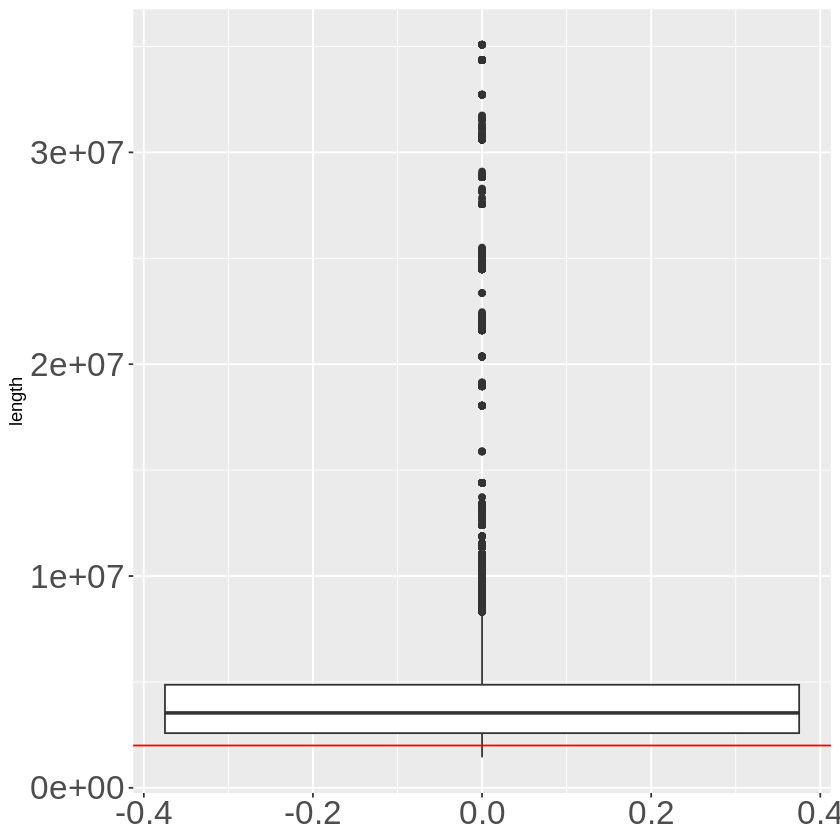

In [55]:
## Distribution of extended regions

extended_final %>% mutate(length = end - start) %>% ggplot(aes(y = length)) + geom_boxplot() +
    geom_hline(yintercept = 2000000, color = "red")+ theme(axis.text = element_text(size = 20))  

In [56]:
extended_final %>% mutate(length = end - start) %>% pull(length) %>% max() 
extended_final %>% mutate(length = end - start) %>% pull(length) %>% mean() 

[1] 35080000

[1] 4653395

After extending, most of the extended regions have a length longer than 2M. There are still some regions with length shorter than 2M. For example if one gene is at the start of one chromosome, then extend to the left, the original cis window will shorter than 2M, so when merged with TADB this region can still be shorter than 2M.

We should no longer find again what genes are in each extended-TADB. Otherwise for these genes their 1M window may again not covered, then we fall into the loop until we indlude the whole genome.

We will only finemap those genes originally in not extended TADBs, using extended TADB as fine mapping region.

In [68]:
ordered_chr <- c(paste0("chr", as.character(1:22)), "chrX")

extend_cis_ordered <- extended_final %>%
  mutate(chr = factor(chr, levels = ordered_chr)) %>%
  arrange(chr) %>% rename(`#chr` = chr) %>% select(`#chr`, start, end, gene_id)

extend_cis_ordered %>% write_tsv("../../reference_data/TAD/TADB_enhanced_cis.bed")

#### Extended TADB

In [58]:
# add the end of chromosome info so that we won't have cis window outside of chromosome

cis_TADB = left_join(gene_TADB_tb, chrDF, by = "chr") %>% rename(chr_end = left) %>%
    mutate(cis_start = pmax(0, gene_start - 1000000)) %>%
    mutate(cis_end = pmin(chr_end, gene_end + 1000000))

In [59]:
idx = gene_TADB_tb %>% pull(index) %>% unique()
idx2 = TADB_final %>% pull(index) %>% unique()

In [60]:
cis_TADB %>% head()

chr,gene_start,gene_end,gene_id,start,end,index,chr_end,cis_start,cis_end
<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chr1,11868,14409,ENSG00000223972,0,6480000,TADB1,248956422,0,1014409
chr1,14404,29570,ENSG00000227232,0,6480000,TADB1,248956422,0,1029570
chr1,17369,17436,ENSG00000278267,0,6480000,TADB1,248956422,0,1017436
chr1,29553,31109,ENSG00000243485,0,6480000,TADB1,248956422,0,1031109
chr1,30365,30503,ENSG00000284332,0,6480000,TADB1,248956422,0,1030503
chr1,34554,36081,ENSG00000237613,0,6480000,TADB1,248956422,0,1036081


In [61]:
cis_summary = cis_TADB %>% group_by(index) %>% summarize(min_start = min(cis_start), max_end = max(cis_end))

In [62]:
extend_TADB = left_join(cis_summary, TADB_final, by = "index") %>% mutate(new_start = pmin(start, min_start)) %>%
    mutate(new_end = pmax(end, max_end)) %>% mutate(length = new_end - new_start) %>%
    mutate(old_length = end - start) %>% mutate(length_diff = length - old_length) %>% select(chr, new_start, new_end) %>% 
    rename(start = new_start, end = new_end) %>% mutate(index = paste0("TADB", row_number()))

For the extended TADB, one gene can be in multiple extended TADBs, even more than 2, as expected.

In [63]:
left_join(extend_TADB, all_gene, by = "chr") %>% filter(gene_start >= start & gene_end <= end) %>% 
    group_by(gene_id) %>% count() %>% group_by(n) %>% count()

Warning message in left_join(extend_TADB, all_gene, by = "chr"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


n,nn
<int>,<int>
1,12330
2,32049
3,13938
4,1611
5,89


In [64]:
nrow(extend_TADB)

[1] 1381

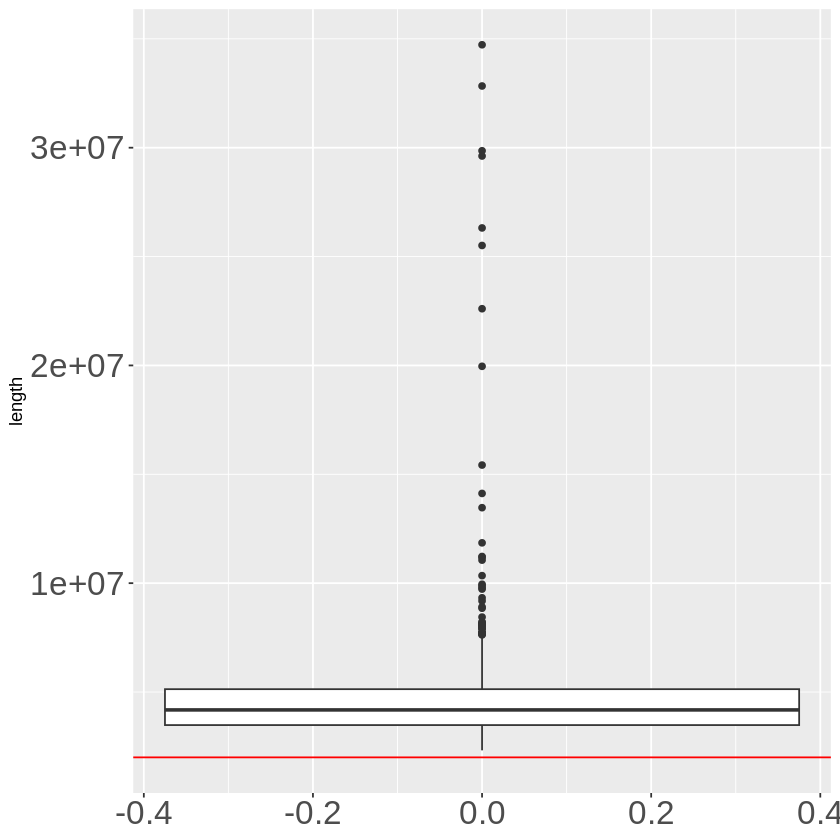

In [65]:
# extend_TADB length distribution
extend_TADB  %>% 
    mutate(length = end - start) %>% ggplot(aes(y = length)) + geom_boxplot() +
    geom_hline(yintercept = 2000000, color = "red")+ theme(axis.text = element_text(size = 20))  

In [66]:
ordered_chr <- c(paste0("chr", as.character(1:22)), "chrX")

extend_TADB <- extend_TADB %>%
  mutate(chr = factor(chr, levels = ordered_chr)) %>%
  arrange(chr, start) %>% rename(`#chr` = chr) %>% mutate(index = paste0("TADB_", row_number()))

In [67]:
extend_TADB %>% write_tsv("../../reference_data/TAD/extended_TADB.bed")

Compared with TADB-enhanced cis window, extended TADB is longer in length.

## Troubleshooting

| Step | Substep | Problem | Possible Reason | Solution |
|------|---------|---------|------------------|---------|
|  |  |  |  |  |


